In [1]:
%matplotlib inline


Training a classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful.
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful.

Specifically for ``vision``, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.utils.data.DataLoader is an iterator which provides features for :

*Batching the data

*Shuffling the data

*Load the data in parallel using multiprocessing workers.

Parameters used below should be clear.

In [4]:
 def  myrgb2gray(x):
        x=x.convert('L')
        x=x.resize((32,32))
        return x

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),   
    transforms.Lambda(lambda x: myrgb2gray(x)),
    transforms.ToTensor(),
])

In [6]:
traindir = './imgfolder/train/'

trainset = torchvision.datasets.ImageFolder(traindir,transform)

trainloader = torch.utils.data.DataLoader(

    trainset, batch_size=5, shuffle=True, num_workers=2)

Let us show some of the training images, for fun.



In [7]:
testdir = './imgfolder/test/'
test_batch_size=8;
testset = torchvision.datasets.ImageFolder(traindir,transform)

testloader = torch.utils.data.DataLoader(

    testset, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [8]:
classes = ('ellipse', 'rectangle', 'triangle')
num_of_classes=3;

triangle ellipse rectangle ellipse rectangle


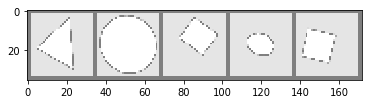

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images (num of images = batch_size)
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

Define a Convolution Neural Network


The neural network below ill take 3-channel images as inputs.



In [10]:
print(images.shape)

torch.Size([5, 1, 32, 32])


In [11]:
print(labels)


 2
 0
 1
 0
 1
[torch.LongTensor of size 5]



In [12]:
print(images.size())

torch.Size([5, 1, 32, 32])


In [13]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
oldnet = net
print(net)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

It might take for a while.



In [15]:
net.cuda()
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # inputs.shape: torch.Size([5, 3, 32, 32])    
        # wrap them in Variable
        
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 1.335
[1,  1000] loss: 1.125
[2,   500] loss: 1.117
[2,  1000] loss: 1.110
[3,   500] loss: 1.071
[3,  1000] loss: 1.010
[4,   500] loss: 0.923
[4,  1000] loss: 0.831
[5,   500] loss: 0.675
[5,  1000] loss: 0.611
[6,   500] loss: 0.539
[6,  1000] loss: 0.492
[7,   500] loss: 0.450
[7,  1000] loss: 0.426
[8,   500] loss: 0.381
[8,  1000] loss: 0.378
[9,   500] loss: 0.372
[9,  1000] loss: 0.289
[10,   500] loss: 0.268
[10,  1000] loss: 0.269
[11,   500] loss: 0.230
[11,  1000] loss: 0.218
[12,   500] loss: 0.177
[12,  1000] loss: 0.216
[13,   500] loss: 0.161
[13,  1000] loss: 0.154
[14,   500] loss: 0.119
[14,  1000] loss: 0.134
[15,   500] loss: 0.117
[15,  1000] loss: 0.099
Finished Training


Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



('GroundTruth: ', 'triangle rectangle rectangle triangle ellipse triangle ellipse rectangle')


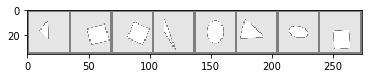

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images, labels = Variable(images.cuda()), Variable(labels.cuda())

#print(images.shape)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(labels.size()[0])))

Okay, now let us see what the neural network thinks these examples above are:



In [17]:
images=images.cuda()

In [18]:
outputs = net(Variable(images))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [19]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(labels.size()[0])))

('Predicted: ', 'triangle rectangle rectangle triangle ellipse triangle ellipse rectangle')


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [20]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    
    images, labels = images.cuda(), labels.cuda()
    
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 97 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [21]:
class_correct = list(0. for i in range(num_of_classes))
class_total = list(0. for i in range(num_of_classes))
for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(labels.size()[0]):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(num_of_classes):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of ellipse : 100 %
Accuracy of rectangle : 95 %
Accuracy of triangle : 96 %


Saving the results

In [22]:
torch.save(net.state_dict(), './savedModels/geomShapesNet.dat')

In [23]:
net2=Net().cuda()

In [24]:
net2.load_state_dict(torch.load('./savedModels/geomShapesNet.dat'))

In [25]:

outputs = net2(Variable(images.cuda()))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(labels.size()[0])))

('Predicted: ', 'ellipse ellipse triangle rectangle ellipse ellipse ellipse rectangle')


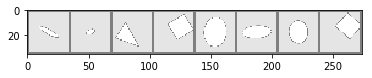

In [26]:
imshow(torchvision.utils.make_grid(images.cpu()))